In [91]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn, optim
from torch.autograd import Variable as V
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
print('PyTorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
print('Is GPU available:', torch.cuda.is_available())

PyTorch version: 0.4.1
torchvision version: 0.2.1
Is GPU available: False


In [92]:
# hyperparameters
n_epochs = 10
batchsize = 64
learning_rate = 0.001
use_gpu = torch.cuda.is_available()

In [113]:
# データセットの読み込み、正規化、ミニバッチSGDのためのデータローダーの作成
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_train = datasets.MNIST(root = './data',
                             train = True,
                             transform = tf,
                             download = True)
mnist_test = datasets.MNIST(root = './data',
                            train = False,
                            transform = tf)
mnist_train_loader = DataLoader(mnist_train, batch_size = batchsize, shuffle = True)
mnist_test_loader = DataLoader(mnist_test, batch_size = batchsize, shuffle = False)
print('train_data:', len(mnist_train))
print('test_data:', len(mnist_test))

train_data: 60000
test_data: 10000


tensor([[9, 4, 4, 2, 7],
        [8, 4, 0, 2, 0],
        [9, 8, 8, 8, 9],
        [8, 6, 9, 8, 1],
        [4, 6, 1, 1, 3]])


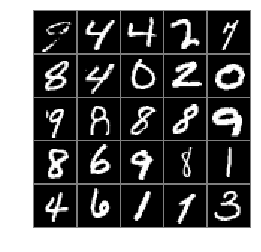

In [94]:
# データの可視化
def imshow(img):
    npimg = img.numpy() * 0.5 + 0.5
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
n_show = 25
n_row = 5
images, labels = iter(mnist_train_loader).next()
images, labels = images[:n_show], labels[:n_show]
imshow(make_grid(images, nrow = n_row, padding = 1))
plt.axis('off')
print(labels.view(-1, n_row))

In [95]:
# 畳み込みニューラルネットワーク（MNIST用）
class CNN_MNIST(nn.Module):
    def __init__(self):
        super(CNN_MNIST, self).__init__()
        self.layers1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layers2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.fc = nn.Linear(7 * 7 * 16, 10)
        
    def forward(self, x):
        out = self.layers1(x)
        out = self.layers2(out)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        return out

In [96]:
# ネットワークを実体化、ロス関数とオプティマイザの定義
net = CNN_MNIST()
if use_gpu:
    net.cuda()
    
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

# モデルの構造、ロス関数、オプティマイザの表示
print('Model:\n', net)
print('\nLoss function:\n', loss_fn)
print('\nOptimizer:\n', optimizer)

Model:
 CNN_MNIST(
  (layers1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

Loss function:
 CrossEntropyLoss()

Optimizer:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [97]:
# 学習を行う関数
def train(train_loader):
    net.train()
    running_loss = 0
    for inputs, targets in train_loader:
        if use_gpu:
            inputs = V(inputs.cuda())
            targets = V(targets.cuda())
        else:
            inputs = V(inputs)
            targets = V(targets)
            
        outputs = net(inputs)
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data.item()
    
    train_loss = running_loss / len(train_loader)
    return train_loss

In [98]:
# バリデーションを行う関数
def valid(test_loader):
    net.eval()
    running_loss = 0
    correct = 0
    total = 0
    for (inputs, targets) in test_loader:
        with torch.no_grad():
            if use_gpu:
                inputs = V(inputs.cuda())
                targets = V(targets.cuda())
            else:
                inputs = V(inputs)
                targets = V(targets)
            
            outputs = net(inputs)
            loss = loss_fn(outputs, targets)
            
        running_loss += loss.data.item()
        _, preds = torch.max(outputs.data, 1)
        correct += (preds == targets).float().sum()
        total += targets.size(0)

    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc

In [101]:
# 学習の実行と、モデルの保存（学習ログは.npyで、モデル状態は.pthで）
loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(n_epochs):
    loss = train(mnist_train_loader)
    val_loss, val_acc = valid(mnist_test_loader)
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print('epoch[%d/%d], loss:%1.4f val_loss:%1.4f val_acc:%1.4f' % (epoch, n_epochs, loss, val_loss, va_acc))

np.save('./mnist_result/loss_list.npy', np.array(loss_list))
np.save('./mnist_result/val_loss_list.npy', np.array(val_loss_list))
np.save('./mnist_result/val_acc_list.npy', np.array(val_acc_list))
torch.save(net.state_dict(), './mnist/result/CNN_MNIST.pth')

KeyboardInterrupt: 

In [88]:
# 学習状況の表示とモデルの読み込み

array(100.71958234)